In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

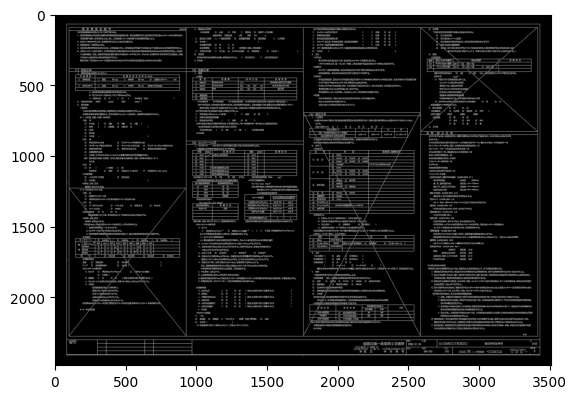

In [23]:
image = cv2.imread('ocr_file_image.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(image_gray, 150, 200)
plt.imshow(edges,cmap = 'gray')


<function matplotlib.pyplot.show(close=None, block=None)>

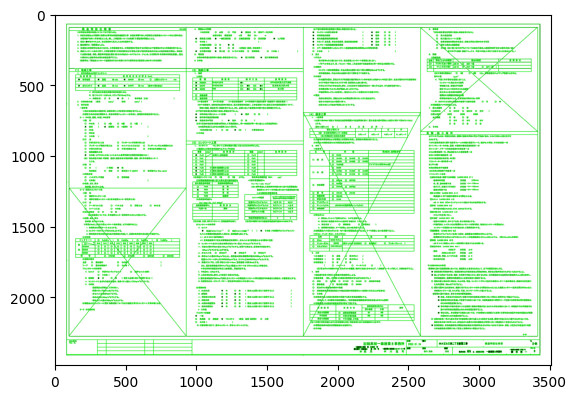

In [24]:
contours, hierarchy = cv2.findContours(image=edges, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

image_copy = image.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)

plt.imshow(image_copy[:,:,::-1])
plt.show

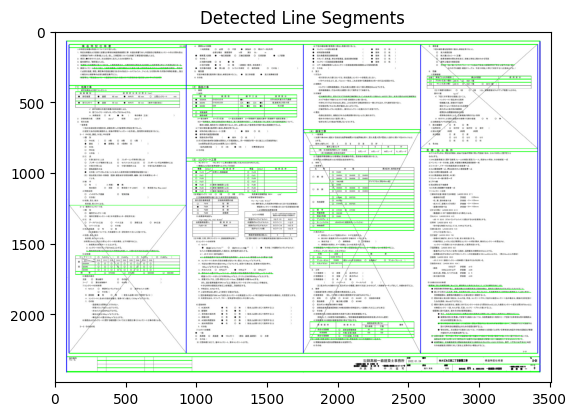

In [25]:
linesP = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=500, maxLineGap=10)

# Tạo ảnh mới để vẽ các đoạn thẳng
line_image = np.copy(image)

horizontal_lines = []
vertical_lines = []
# Lặp qua từng đoạn thẳng phát hiện được và vẽ chúng lên ảnh
if linesP is not None:
    for line in linesP:
        x1, y1, x2, y2 = line[0]
        # Tính độ dốc của đoạn thẳng
        if x2 != x1:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = np.inf
        
        # Kiểm tra xem đoạn thẳng có phải là ngang hoặc dọc
        if np.abs(slope) < 0.1:  # Đoạn thẳng ngang
            horizontal_lines.append((x1, y1, x2, y2))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vẽ màu xanh cho đường ngang
        elif np.abs(slope) > 10:  # Đoạn thẳng dọc (giá trị 10 là ngưỡng tùy chọn, bạn có thể điều chỉnh)
            vertical_lines.append((x1, y1, x2, y2))
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Vẽ màu đỏ cho đường dọc

# Hiển thị ảnh với các đoạn thẳng đã vẽ
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Line Segments')
plt.show()

# lines = cv2.HoughLines(edges, 1, np.pi/180, 1200)

# img_copy = image.copy()
# if lines is not None:
#     for line in lines:
#         rho, theta = line[0]
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a*rho
#         y0 = b*rho
#         x1 = int(x0 + 10000*(-b))
#         y1 = int(y0 + 10000*(a))
#         x2 = int(x0 - 10000*(-b))
#         y2 = int(y0 - 10000*(a))
        
#         cv2.line(img_copy, (x1,y1), (x2,y2), (0,0,255), 2)
# plt.imshow(img_copy)

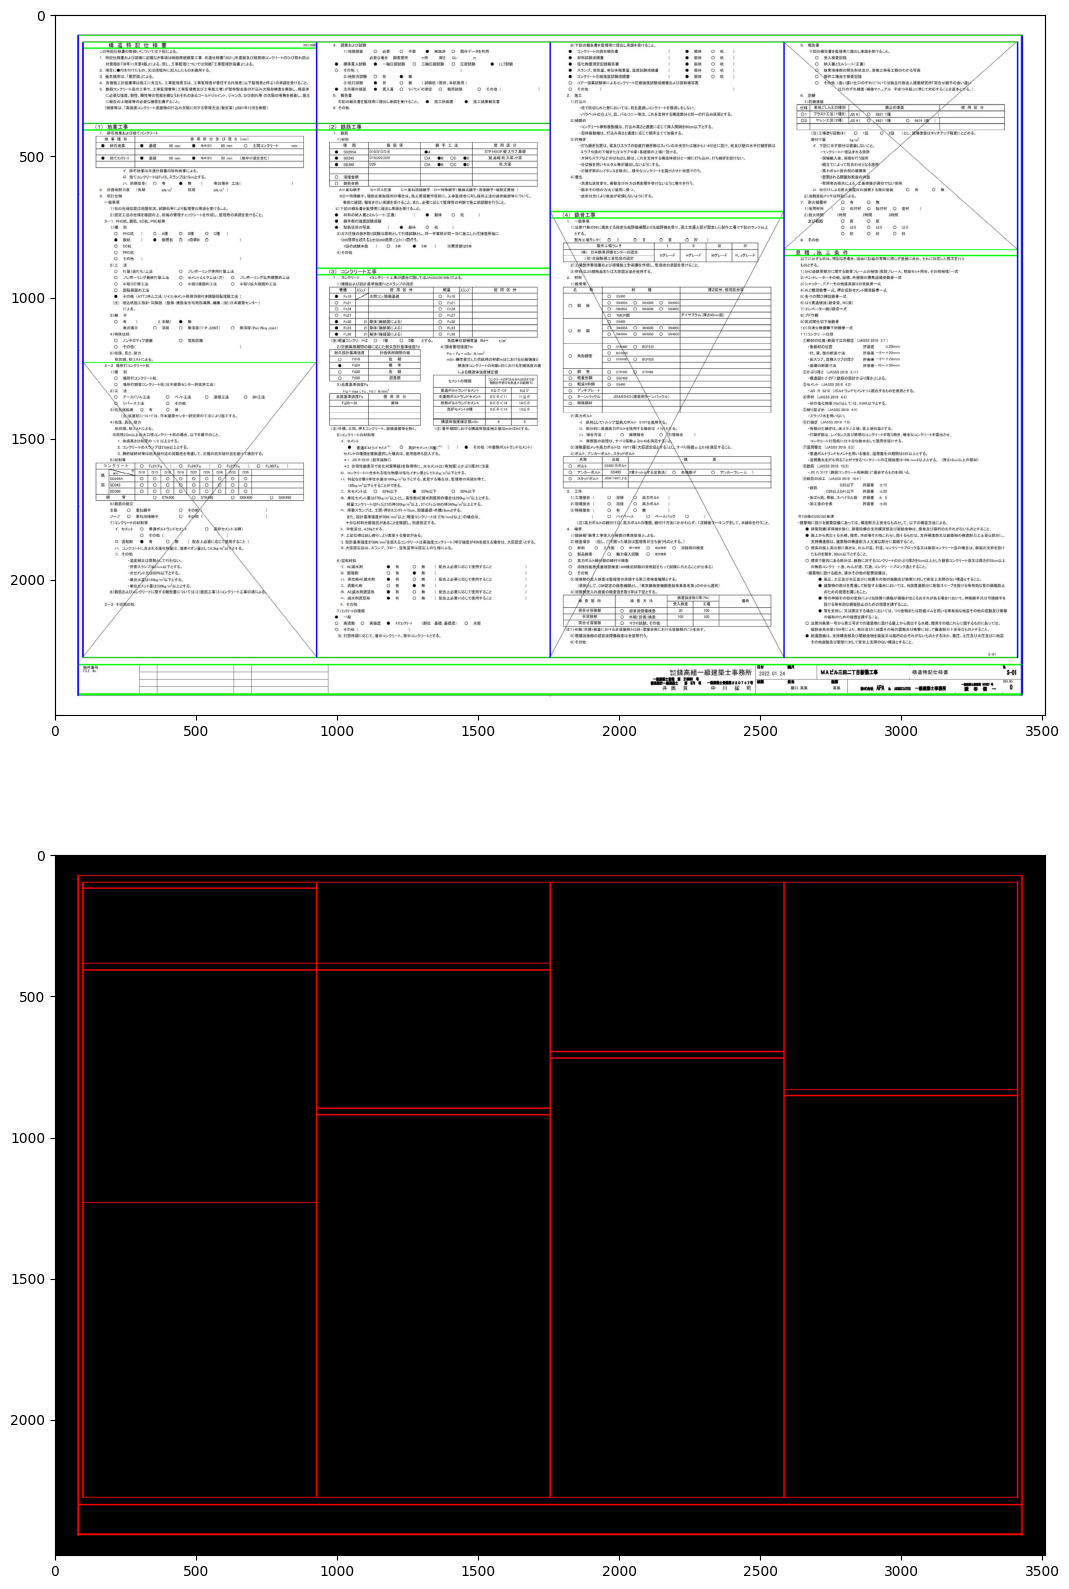

In [26]:
# Phát hiện các đoạn thẳng bằng Probabilistic Hough Line Transform
linesP = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=500, maxLineGap=10)

# Tạo ảnh mới để vẽ các đoạn thẳng
line_image = np.copy(image)
mask = np.zeros_like(image)

# Danh sách các đoạn thẳng ngang và dọc
horizontal_lines = []
vertical_lines = []

# Lặp qua từng đoạn thẳng phát hiện được và chỉ lấy các đoạn thẳng ngang hoặc dọc
if linesP is not None:
    for line in linesP:
        x1, y1, x2, y2 = line[0]
        # Tính độ dốc của đoạn thẳng
        if x2 != x1:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = np.inf
        
        # Kiểm tra xem đoạn thẳng có phải là ngang hoặc dọc
        if np.abs(slope) < 0.1:  # Đoạn thẳng ngang
            horizontal_lines.append((x1, y1, x2, y2))
        elif np.abs(slope) > 10:  # Đoạn thẳng dọc (giá trị 10 là ngưỡng tùy chọn, bạn có thể điều chỉnh)
            vertical_lines.append((x1, y1, x2, y2))

# Kiểm tra các đường ngang để xem chúng có phải là cầu nối của các đường dọc hay không
connecting_horizontal_lines = []

bonus_pixel = 2
for h_line in horizontal_lines:
    x1_h, y1_h, x2_h, y2_h = h_line
    
    # Kiểm tra xem hai điểm đầu và cuối của đường ngang có nằm trên các đường dọc nào không
    connected_vertical_lines = 0
    
    for v_line in vertical_lines:
        x1_v, y1_v, x2_v, y2_v = v_line
        
        if min(x1_v, x2_v) - bonus_pixel <= x1_h <= max(x1_v, x2_v) + bonus_pixel and min(y1_v, y2_v) - bonus_pixel <= y1_h <= max(y1_v, y2_v) + bonus_pixel:
            connected_vertical_lines += 1
        if min(x1_v, x2_v) - bonus_pixel <= x2_h <= max(x1_v, x2_v) + bonus_pixel and min(y1_v, y2_v) - bonus_pixel <= y2_h <= max(y1_v, y2_v) + bonus_pixel:
            connected_vertical_lines += 1
    
    # Chỉ giữ lại các đường ngang kết nối với ít nhất hai đường dọc
    if connected_vertical_lines >= 2:
        connecting_horizontal_lines.append(h_line)
        cv2.line(line_image, (x1_h, y1_h), (x2_h, y2_h), (0, 255, 0), 2)  # Vẽ màu xanh cho đường ngang kết nối
        cv2.line(mask, (x1_h, y1_h), (x2_h, y2_h), 255, 2)  # Vẽ đường ngang lên mask

# Vẽ các đường dọc lên ảnh
for v_line in vertical_lines:
    x1_v, y1_v, x2_v, y2_v = v_line
    cv2.line(line_image, (x1_v, y1_v), (x2_v, y2_v), (255, 0, 0), 2)  # Vẽ màu đỏ cho đường dọc
    cv2.line(mask, (x1_v, y1_v), (x2_v, y2_v), 255, 2) # Vẽ đường dọc lên mask
    
# Hiển thị ảnh với các đường ngang và dọc đã vẽ
plt.figure(figsize=(20,20))
plt.subplot(2,1,1); plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.subplot(2,1,2); plt.imshow(mask, cmap='gray')
plt.show()

# # In ra các đường ngang kết nối
# print("Detected Connecting Horizontal Lines:")
# for line in connecting_horizontal_lines:
#     print(f"Segment: ({line[0]}, {line[1]}) to ({line[2]}, {line[3]})")


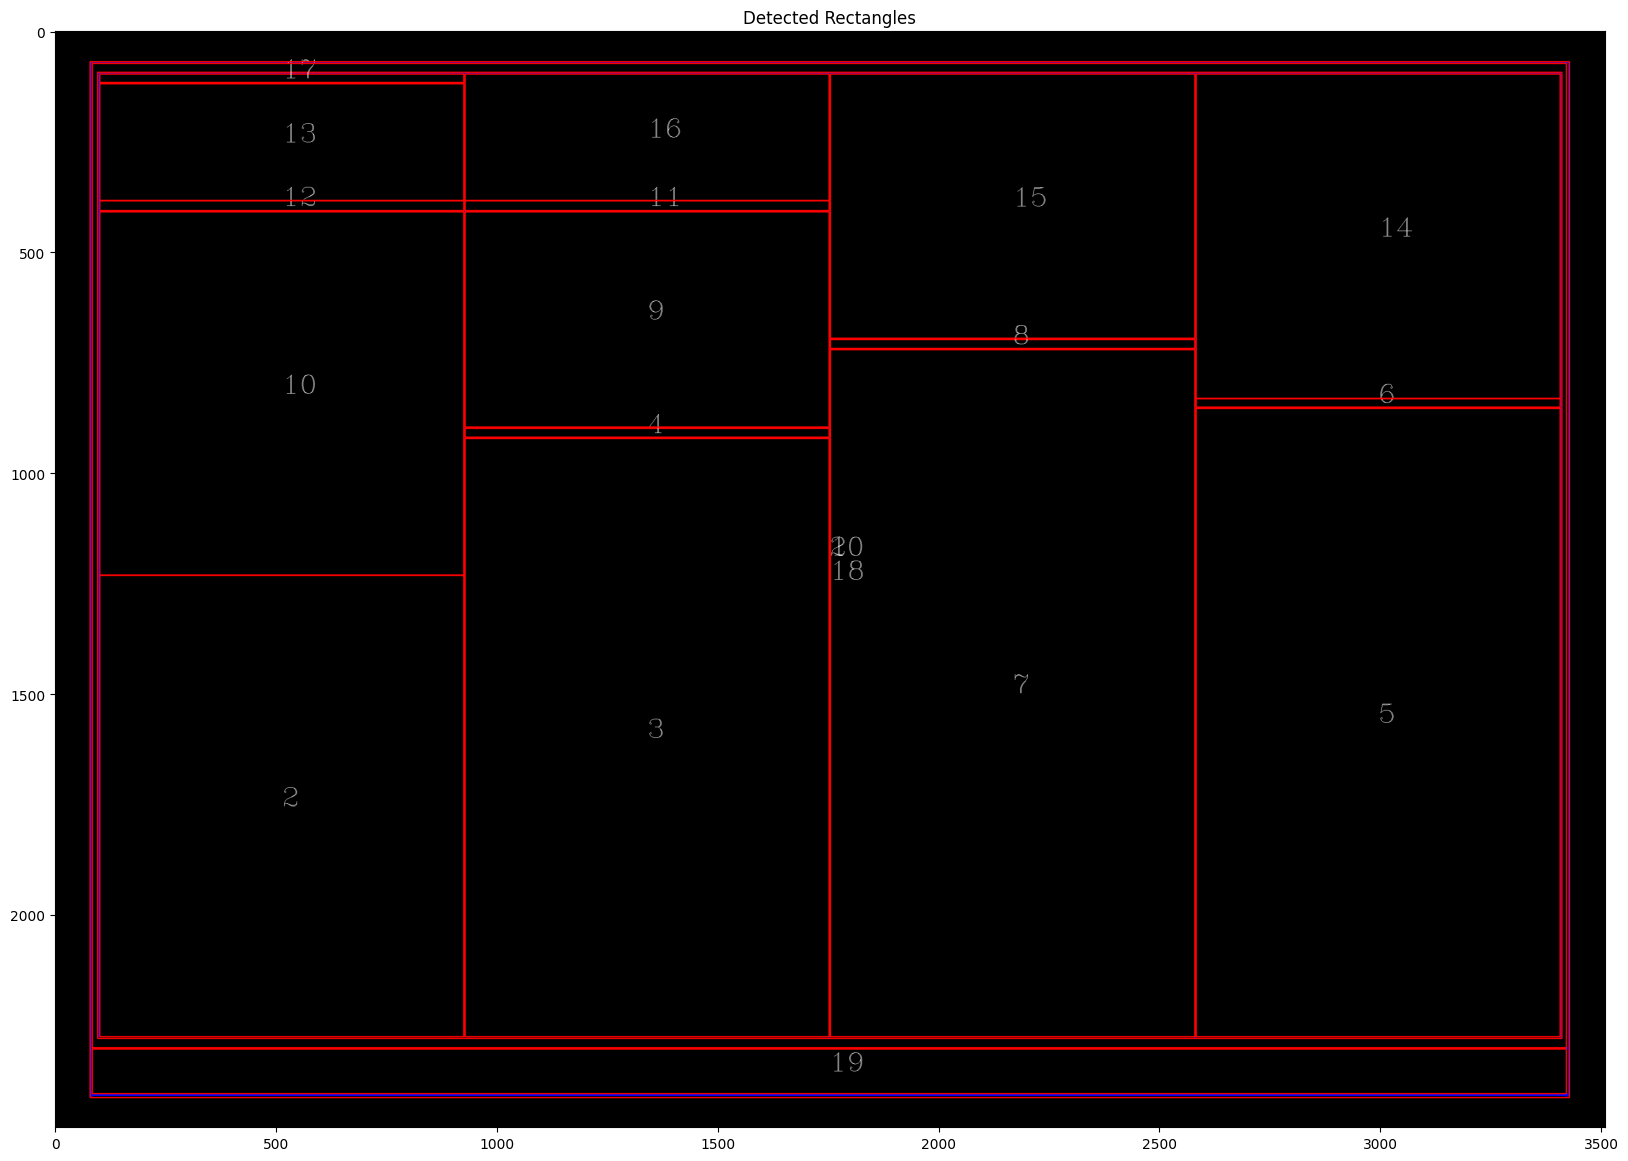

Detected Rectangles:
Rectangle 1: x=79, y=69, width=3349, height=2345
Rectangle 2: x=84, y=73, width=3337, height=2228
Rectangle 3: x=96, y=93, width=3315, height=2187
Rectangle 4: x=1755, y=721, width=825, height=1555
Rectangle 5: x=2583, y=854, width=824, height=1422
Rectangle 6: x=928, y=922, width=824, height=1354
Rectangle 7: x=101, y=1232, width=824, height=1044
Rectangle 8: x=101, y=409, width=824, height=822
Rectangle 9: x=2583, y=97, width=824, height=734
Rectangle 10: x=1755, y=97, width=825, height=598
Rectangle 11: x=928, y=409, width=824, height=487
Rectangle 12: x=84, y=2304, width=3337, height=101
Rectangle 13: x=928, y=97, width=824, height=286
Rectangle 14: x=101, y=119, width=824, height=264
Rectangle 15: x=928, y=384, width=824, height=22
Rectangle 16: x=101, y=384, width=824, height=22
Rectangle 17: x=1755, y=698, width=825, height=20
Rectangle 18: x=928, y=899, width=824, height=20
Rectangle 19: x=2583, y=832, width=824, height=19
Rectangle 20: x=101, y=97, width=8

In [27]:
# Chuyển đổi sang ảnh grayscale
gray_image = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# Áp dụng phép threshold để chuyển đổi thành ảnh nhị phân
_, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

# Tìm contours trong ảnh nhị phân
contours, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

line_image = mask.copy()
# Lặp qua từng contour để vẽ và trích xuất hình chữ nhật
rectangles = []
count = 0
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Lọc các hình chữ nhật có diện tích và tỷ lệ phù hợp
    area = cv2.contourArea(contour)
    if area > 10000 and w > 10 and h > 10 and h < line_image.shape[0]:
        count += 1
        rectangles.append((x, y, w, h))
        cv2.rectangle(line_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Vẽ bounding box màu đỏ
        cv2.putText(line_image, str(count), (int(x + w / 2), int(y + h / 2)), fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=2, color=(255, 255, 255))

rectangles_sorted = sorted(rectangles, key=lambda rect: rect[2] * rect[3], reverse=True)

# Hiển thị ảnh với các bounding box đã vẽ
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Rectangles')
plt.show()

# In ra các hình chữ nhật trích xuất được
print("Detected Rectangles:")
for i, (x, y, w, h) in enumerate(rectangles_sorted, 1):
    print(f"Rectangle {i}: x={x}, y={y}, width={w}, height={h}")

In [14]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image

import os

ocr = PaddleOCR(use_angle_cls=True, lang='japan')  # cần chạy một lần để tải và load model vào bộ nhớ

[2024/07/23 03:20:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\ADMIN/.paddleocr/whl\\rec\\japan\\japan_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320'

In [15]:
original_image = cv2.imread('ocr_file_image.jpg')

for i, (x, y, w, h) in enumerate(rectangles_sorted[3:], start=1):
    # Cắt phần hình chữ nhật từ ảnh gốc
    image_crop = original_image[y-10:y+h+10, x-10:x+w+10]
    
    # Đổi định dạng màu từ BGR sang RGB để phù hợp với PaddleOCR
    image_rgb = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
    
    # Nhận dạng văn bản từ hình ảnh cắt được
    result = ocr.ocr(image_rgb, cls=True)
    
    # Lưu kết quả nhận dạng vào file text
    result_text = ''
    for idx in range(len(result)):
        res = result[idx]
        for line in res:
            result_text += line[1][0] + '\n'
    
    # Lưu kết quả vào thư mục image_result
    save_path = os.path.join('image_result_v2', f'result_{i}.txt')
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(result_text)
    
    # Vẽ kết quả nhận dạng lên ảnh gốc 
    height, width, channels = image_rgb.shape
    new_height = height + 100
    new_image = np.ones((new_height, width, channels), dtype=np.uint8) * 255  
    new_image[:height, :width, :] = image_rgb
    
    boxes = [line[0] for line in result[0]]
    txts = [line[1][0] for line in result[0]]
    scores = [line[1][1] for line in result[0]]
    im_show = draw_ocr(new_image, boxes, txts, scores, font_path='NotoSansJP-VariableFont_wght.ttf')
    im_show = Image.fromarray(im_show)

    # Lưu ảnh kết quả 
    im_show.save(os.path.join('image_result_v2', f'result_{i}.jpg'))

print("Processing completed and results saved in 'image_result' folder.")

[2024/07/23 03:20:13] ppocr DEBUG: dt_boxes num : 154, elapsed : 0.471057653427124
[2024/07/23 03:20:13] ppocr DEBUG: cls num  : 154, elapsed : 0.2785341739654541
[2024/07/23 03:20:17] ppocr DEBUG: rec_res num  : 154, elapsed : 4.048364639282227
[2024/07/23 03:20:18] ppocr DEBUG: dt_boxes num : 226, elapsed : 0.4585435390472412
[2024/07/23 03:20:18] ppocr DEBUG: cls num  : 226, elapsed : 0.25054359436035156
[2024/07/23 03:20:25] ppocr DEBUG: rec_res num  : 226, elapsed : 7.2152581214904785
[2024/07/23 03:20:26] ppocr DEBUG: dt_boxes num : 215, elapsed : 0.15651416778564453
[2024/07/23 03:20:26] ppocr DEBUG: cls num  : 215, elapsed : 0.352557897567749
[2024/07/23 03:20:32] ppocr DEBUG: rec_res num  : 215, elapsed : 6.351590156555176
[2024/07/23 03:20:33] ppocr DEBUG: dt_boxes num : 146, elapsed : 0.44257164001464844
[2024/07/23 03:20:33] ppocr DEBUG: cls num  : 146, elapsed : 0.28496432304382324
[2024/07/23 03:20:38] ppocr DEBUG: rec_res num  : 146, elapsed : 4.289086818695068
[2024/07/